In [144]:
import h5py, os
import numpy as np
import SimpleITK as sitk
import caffe
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [227]:
path_patients='/Users/trullro/Downloads/patient_test/'

_, patients, _ = os.walk(path_patients).next()#every folder is a patient
print patients

['Bailjac', 'BMD_OSEO_001-TURBE', 'BMD_OSEO_002-OUMME', 'BMD_OSEO_003-QUECA', 'BMD_OSEO_004-GARAB', 'BMD_OSEO_005-DUBGE', 'BMD_OSEO_006-CANJE', 'BMD_OSEO_007-BREJE', 'BMD_OSEO_008-DAUJE', 'BMD_OSEO_009-AMOCL', 'BMD_OSEO_010-GRACBE', 'BMD_OSEO_011-LIEAN', 'BMD_OSEO_012-MOTRO', 'BMD_OSEO_013-HEUCA', 'BMD_OSEO_014-LENMI', 'BMD_OSEO_015-SAIDA', 'BMD_OSEO_016-NICMA', 'Bouhe', 'Chrmi', 'Desro', 'Domjo', 'Fouan', 'Levph', 'Moosh', 'Nolbe', 'Ricbe', 'Tasja', 'Verbe']


(512, 512, 246)


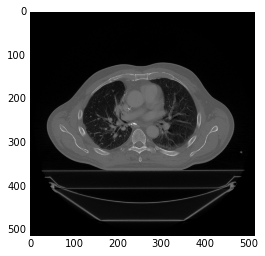

In [233]:
#body is the manual segmentation of the body; from here we will sample bg patches
body=scio.loadmat(os.path.join(path_patients,patients[0],'contour.mat'))
body=body['vol']

#ctvol is the data volume
ctvolitk=sitk.ReadImage(os.path.join(path_patients,patients[0],patients[0]+'.nii.gz')) 
ctvol=sitk.GetArrayFromImage(ctvolitk)   
ctvol=np.transpose(ctvol,(1,2,0))#matlab order, rows,cols,slices

#segnp is the groundtruth volume
segitk=sitk.ReadImage(os.path.join(path_patients,patients[0],'GT.nii.gz'))
segnp=sitk.GetArrayFromImage(segitk)
segnp=np.transpose(segnp,(1,2,0))#matlab order, rows,cols,slices
[rows,cols,slices]= ctvol.shape
print ctvol.shape
plt.imshow(ctvol[:,:,150],cmap='gray')



In [245]:
patch_sz=[32,32,16]
all_organs_mask=segnp>0 #every voxel belonging to an organ will be one
maskborders=np.ones_like(all_organs_mask)
# we put zero so we cant choose patches containing elements out of range

#maskborders[rows-patch_sz[0]+1:rows,cols-patch_sz[1]+1:cols,:]=0; 


maskborders[rows-patch_sz[0]+1:rows,:,:]=0; 
maskborders[:,cols-patch_sz[1]+1:cols,:]=0; 
maskborders[:,:,slices-patch_sz[2]+1:slices]=0;

maskbody=np.logical_and(body,maskborders) 
mask_eso=(segnp==1)*maskborders
mask_heart=(segnp==2)*maskborders;
mask_trach=(segnp==3)*maskborders;
mask_aorta=(segnp==4)*maskborders;
#plt.imshow(mask_trach[:,:,160],cmap='gray')




246
366
480
230


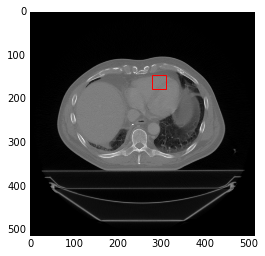

In [246]:
bgidx=np.where(np.logical_and(maskbody,np.logical_not(all_organs_mask)>0))
esoidx=np.where(mask_eso==1)
heartidx=np.where(mask_heart==1)
trachidx=np.where(mask_trach==1)
aortaidx=np.where(mask_aorta==1)

print slices
print bgidx[0].max()
print bgidx[1].max()
print bgidx[2].max()
fig,ax = plt.subplots(1)

npatch=100;

ax.imshow(ctvol[:,:,heartidx[2][npatch]],cmap='gray')

# Create a Rectangle patch
rect = patches.Rectangle((heartidx[1][npatch],heartidx[0][npatch]),patch_sz[0],patch_sz[1],linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [170]:
X=ctvol[heartidx[0][npatch]:heartidx[0][npatch]+patch_sz[0],heartidx[1][npatch]:heartidx[1][npatch]+patch_sz[1],heartidx[2][npatch]:heartidx[2][npatch]+patch_sz[2]]
y=segnp[heartidx[0][npatch]:heartidx[0][npatch]+patch_sz[0],heartidx[1][npatch]:heartidx[1][npatch]+patch_sz[1],heartidx[2][npatch]:heartidx[2][npatch]+patch_sz[2]]
print X.shape
print y.shape

(32, 32, 16)
(32, 32, 16)


#This is now for all patients available#

In [249]:
patch_sz=[32,32,16]
npacthes=1000 #patches per class
nclasses=5#including bg

X=np.zeros((len(patients)*npatches*nclasses,1,patch_sz[2],patch_sz[0],patch_sz[1]))
y=np.zeros((len(patients)*npatches*nclasses,patch_sz[2],patch_sz[0],patch_sz[1]))


idpatch=0

for idx,namepatient in enumerate(patients):
    body=scio.loadmat(os.path.join(path_patients,namepatient,'contour.mat'))
    body=body['vol']

    #ctvol is the data volume
    ctvolitk=sitk.ReadImage(os.path.join(path_patients,namepatient,namepatient+'.nii.gz')) 
    ctvol=sitk.GetArrayFromImage(ctvolitk)   
    ctvol=np.transpose(ctvol,(1,2,0))#matlab order, rows,cols,slices

    #segnp is the groundtruth volume
    segitk=sitk.ReadImage(os.path.join(path_patients,namepatient,'GT.nii.gz'))
    segnp=sitk.GetArrayFromImage(segitk)
    segnp=np.transpose(segnp,(1,2,0))#matlab order, rows,cols,slices
    [rows,cols,slices]= ctvol.shape
    
    all_organs_mask=segnp>0 #every voxel belonging to an organ will be one
    
    maskborders=np.ones_like(all_organs_mask)
    #maskborders[rows-patch_sz[0]+1:rows,cols-patch_sz[1]+1:cols,slices-patch_sz[2]+1:slices]=0;# we put zero so we 
    #cant choose patches containing elements out of range
    maskborders[rows-patch_sz[0]+1:rows,:,:]=0; 
    maskborders[:,cols-patch_sz[1]+1:cols,:]=0; 
    maskborders[:,:,slices-patch_sz[2]+1:slices]=0;
    
    maskbody=np.logical_and(body,maskborders) 
    mask_eso=(segnp==1)*maskborders
    mask_heart=(segnp==2)*maskborders;
    mask_trach=(segnp==3)*maskborders;
    mask_aorta=(segnp==4)*maskborders;
    
    bgidx=np.where(np.logical_and(maskbody,np.logical_not(all_organs_mask)>0))    
    esoidx=np.where(mask_eso==1)
    heartidx=np.where(mask_heart==1)
    trachidx=np.where(mask_trach==1)
    aortaidx=np.where(mask_aorta==1)
    
    
    list_rndbg=np.random.choice(len(bgidx[0]), npatches, replace=False)
    list_rndeso=np.random.choice(len(esoidx[0]), npatches, replace=False)
    list_rndheart=np.random.choice(len(heartidx[0]), npatches, replace=False)
    list_rndtrach=np.random.choice(len(trachidx[0]), npatches, replace=False)
    list_rndaort=np.random.choice(len(aortaidx[0]), npatches, replace=False)
    
    for i in list_rndbg:
        index=np.array((bgidx[0][i], bgidx[1][i], bgidx[2][i]))
        X[idpatch,0,:,:,:]=ctvol[index[0]:index[0]+patch_sz[0],index[1]:index[1]+patch_sz[1],index[2]:index[2]+patch_sz[2]].transpose((2,0,1))
        idpatch=idpatch+1
    
    for i in list_rndeso:
        index=np.array((esoidx[0][i], esoidx[1][i], esoidx[2][i]))
        X[idpatch,0,:,:,:]=ctvol[index[0]:index[0]+patch_sz[0],index[1]:index[1]+patch_sz[1],index[2]:index[2]+patch_sz[2]].transpose((2,0,1))
        idpatch=idpatch+1
    
    for i in list_rndheart:
        index=np.array((heartidx[0][i], heartidx[1][i], heartidx[2][i]))
        X[idpatch,0,:,:,:]=ctvol[index[0]:index[0]+patch_sz[0],index[1]:index[1]+patch_sz[1],index[2]:index[2]+patch_sz[2]].transpose((2,0,1))
        idpatch=idpatch+1
    
    for i in list_rndtrach:
        index=np.array((trachidx[0][i], trachidx[1][i], trachidx[2][i]))
        X[idpatch,0,:,:,:]=ctvol[index[0]:index[0]+patch_sz[0],index[1]:index[1]+patch_sz[1],index[2]:index[2]+patch_sz[2]].transpose((2,0,1))
        idpatch=idpatch+1
    
    for i in list_rndaort:
        index=np.array((aortaidx[0][i], aortaidx[1][i], aortaidx[2][i]))
        X[idpatch,0,:,:,:]=ctvol[index[0]:index[0]+patch_sz[0],index[1]:index[1]+patch_sz[1],index[2]:index[2]+patch_sz[2]].transpose((2,0,1))
        idpatch=idpatch+1


    print namepatient+' done!'
    
print 'everything done!'
    

    

Bailjac done!
BMD_OSEO_001-TURBE done!
BMD_OSEO_002-OUMME done!
BMD_OSEO_003-QUECA done!
BMD_OSEO_004-GARAB done!
BMD_OSEO_005-DUBGE done!
BMD_OSEO_006-CANJE done!
BMD_OSEO_007-BREJE done!
BMD_OSEO_008-DAUJE done!
BMD_OSEO_009-AMOCL done!
BMD_OSEO_010-GRACBE done!
BMD_OSEO_011-LIEAN done!
BMD_OSEO_012-MOTRO done!
BMD_OSEO_013-HEUCA done!
BMD_OSEO_014-LENMI done!
BMD_OSEO_015-SAIDA done!
BMD_OSEO_016-NICMA done!
Bouhe done!
Chrmi done!
Desro done!
Domjo done!
Fouan done!
Levph done!
Moosh done!
Nolbe done!
Ricbe done!
Tasja done!
Verbe done!
everything done!


In [254]:
dirname = os.path.abspath('./data')
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
    
train_filename = os.path.join(dirname, 'train.h5')
test_filename = os.path.join(dirname, 'test.h5')

# HDF5DataLayer source should be a file containing a list of HDF5 filenames.
# To show this off, we'll list the same data file twice.
comp_kwargs = {'compression': 'gzip', 'compression_opts': 1}

with h5py.File(train_filename, 'w') as f:
    f.create_dataset('data', data=X, **comp_kwargs)
    with open(os.path.join(dirname, 'train.txt'), 'w') as f:
        f.write(train_filename + '\n')